# 04. LSTM with Context-Free Embeddings
In this module. we still using pretrained context-free embeddings (BoW,GloVe and FastText) with more advanced model, the long short-term memory (LSTM) and bidirectional long-short term memory (BiLSTM)

First, we redeploy our training pipeline template from the previous module

## Training Pipeline Template
### Data Set Initiation 

In [4]:
# import data set
import pandas as pd
df = pd.read_csv("data/cleaned-train-tweets.csv", sep="|")

# create PyTorch data set
import torch
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

class DisasterTweetsDataset(Dataset):
    def __init__(self, df, max_vocab_size, vocabulary = None):
        
        # load dataframe
        self.x = df["clean_text"]
        self.y = df["target"]

        # create vocabulary
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                [" ".join([str(text) for text in df["clean_text"]]).split()],
                specials=['<unk>'],
                max_tokens = max_vocab_size)
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary

    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]
        return (y, x)

# initiate dataset and vocabulary
dataset = DisasterTweetsDataset(df, 10000)
vocab = dataset.get_vocab()

### Context-free Word Embeddings

In [5]:
from torchtext.vocab import GloVe, FastText

glove = GloVe(name="6B")
fasttext = FastText(language="en")

# BoW
def collate_into_bow(batch):
    """
    collate the dataset into bag of words representation
    
    input:
        - batch (list(str, int)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create bow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a bow vector
        """

        indices = vocab(str(text).split())
        bows = [0] * len(vocab)
        for index in indices:
            bows[index] += 1 / len(indices)
        return bows

    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

# GloVe
def collate_into_glove(batch):
    """
    collate the dataset into continuous bag of words representation by using
    pretrained GloVe
    
    input:
        - batch (list(int, str)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create cbow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a cbow vector
        """

        tokens = str(text).split()
        vecs = glove.get_vecs_by_tokens(tokens)
        return list(vecs.mean(dim=0))

    label_pipeline = lambda x: int(x) - 1 
    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

# fastText
def collate_into_fasttext(batch):
    """
    collate the dataset into continuous bag of words representation by using
    pretrained fastText
    
    input:
        - batch (list(int, str)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create cbow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a cbow vector
        """

        tokens = str(text).split()
        vecs = fasttext.get_vecs_by_tokens(tokens)
        return list(vecs.mean(dim=0))

    label_pipeline = lambda x: int(x) - 1 
    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

### Training Pipeline


In [2]:
# Initiate a dataloader and split the data into train and validation dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

def new_dataloader(dataset, collate_fn, batch_size=64, split_train_ratio=0.7):
    num_train = int(len(dataset) * split_train_ratio)
    num_valid = len(dataset) - num_train
    train_data, valid_data = random_split(
        dataset,
        [num_train, num_valid]
    )
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    valid_dataloader = DataLoader(
        valid_data, 
        batch_size=batch_size,
        shuffle=False, 
        collate_fn=collate_fn)
    return (train_dataloader, valid_dataloader)

# helper function: repackage hidden
def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.
    """
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# function for training an epoch
def train_an_epoch(dataloader, model, hidden, loss_function, optimizer, 
                   clip_grad, max_norm):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(text, hidden)
        loss = loss_function(output.view(-1, output.size(-1)), label.view(-1))
        loss.backward()
        if clip_grad:
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), 
                max_norm=max_norm # default GRAD_CLIP = 1
            )
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

# function for calculate the accuracy for a given dataloader
def get_accuracy(dataloader, model):
    model.eval()
    with torch.no_grad():
        hidden = None
        total_acc, total_count = 0, 0
        for _, (label, text) in enumerate(dataloader):
            log_probs, hidden = model(text, hidden)
            predicted_label = torch.argmax(log_probs, dim=1)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

# putting all together, create function for training
import matplotlib.pyplot as plt
import time

def training(dataset, collate_fn, batch_size, split_train_ratio, 
             model, epochs, loss_function, optimizer, clip_grad, max_norm):
    
    # create dataloader from dataset
    train_dataloader, valid_dataloader = new_dataloader(
        dataset, collate_fn, batch_size, split_train_ratio)

    # training
    accuracies = []
    max_val_acc = -float("inf")
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        hidden = None
        train_an_epoch(train_dataloader, model, hidden, loss_function, optimizer,
                       clip_grad, max_norm)
        accuracy = get_accuracy(valid_dataloader, model)
        accuracies.append(accuracy)
        time_taken = time.time() - epoch_start_time
        print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
        # persist the best model
        if accuracy > max_val_acc:
            print("the best model has validation accuracy at {}".format(accuracy))
            best_model = type(model)(
                model.rnn_type,  
                model.input_size, 
                model.hidden_size, 
                model.num_labels,
                model.num_layers, 
                model.dropout
            )
            best_model.load_state_dict(model.state_dict())
            max_val_acc = accuracy
    
    plt.plot(range(1, epochs + 1), accuracies)

## The General RNN Classifier
We start with deploy the general RNN classifier. However, in this experiment we use only `LSTM` and `BiLSTM`. But the curious readers can change or modify any settings they would like.

In [4]:
# Initiate an RNN classifier
from torch import nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    """
    Initialize RNN classifier

    Args:
        - rnn_type (str): "LSTM", "BiLSTM", "GRU", "RNN_TANH", "RNN_RELU"
        - input_size (int): size of embedding vector (number of features) 
            for each word (default: 300)
        - hidden_size (int): the number of features in the hidden state (def: 300)
    """
    def __init__(self, rnn_type, input_size, hidden_size, num_labels, 
                 num_layers, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.num_layers = num_layers
        self.dropout = dropout

        self.drop = nn.Dropout(dropout)
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               dropout=dropout)
        elif rnn_type == "BiLSTM":
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               dropout=dropout,
                               bidirectional=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              dropout=dropout)
        elif rnn_type == "RNN_TANH":
            self.rnn = nn.RNN(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              nonlinearity="tanh",
                              dropout=dropout)
        elif rnn_type == "RNN_RELU":
            self.rnn = nn.RNN(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              nonlinearity="relu",
                              dropout=dropout)
        if rnn_type == "BiLSTM":
            self.decoder = nn.Linear(
                in_features=hidden_size * 2, 
                out_features=num_labels
            )
        else:
            self.decoder = nn.Linear(
                in_features=hidden_size, 
                out_features=num_labels
        )

    
    def forward(self, input, hidden0):
        drop_input = self.drop(input)
        output, hidden = self.rnn(drop_input, hidden0)
        output = self.drop(output)
        decoded_output = self.decoder(output)
        decoded_output = F.log_softmax(self.decoder(output), dim=1)
        return decoded_output, hidden
        # return F.log_softmax(self.linear(bow_vec), dim=1)

## Training Models
We train two models: LSTM and bidirectional LSTM, each with three embedding matrices: BoW, GloVe, and fastText.

### LSTM Model
#### BoW

After epoch 1 the validation accuracy is 0.737.
the best model has validation accuracy at 0.7369180801154818
After epoch 2 the validation accuracy is 0.815.
the best model has validation accuracy at 0.815229159148322
After epoch 3 the validation accuracy is 0.821.
the best model has validation accuracy at 0.8210032479249368
After epoch 4 the validation accuracy is 0.831.
the best model has validation accuracy at 0.8307470227354745
After epoch 5 the validation accuracy is 0.843.
the best model has validation accuracy at 0.8428365211115121
After epoch 6 the validation accuracy is 0.841.
After epoch 7 the validation accuracy is 0.845.
the best model has validation accuracy at 0.8448213641284735
After epoch 8 the validation accuracy is 0.860.
the best model has validation accuracy at 0.8599783471670877
After epoch 9 the validation accuracy is 0.860.
After epoch 10 the validation accuracy is 0.861.
the best model has validation accuracy at 0.8614218693612414
After epoch 11 the validation ac

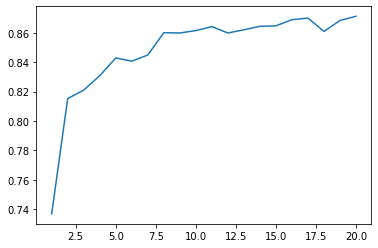

In [5]:
# LSTM Model with BoW
lstm_bow_model = RNNClassifier(
    rnn_type="LSTM",
    input_size=10000,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_bow
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = lstm_bow_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

#### GloVe

After epoch 1 the validation accuracy is 0.776.
the best model has validation accuracy at 0.7757127390833634
After epoch 2 the validation accuracy is 0.783.
the best model has validation accuracy at 0.7832912306026705
After epoch 3 the validation accuracy is 0.784.
the best model has validation accuracy at 0.7838325514254781
After epoch 4 the validation accuracy is 0.787.
the best model has validation accuracy at 0.7874413569108625
After epoch 5 the validation accuracy is 0.787.
After epoch 6 the validation accuracy is 0.794.
the best model has validation accuracy at 0.7941176470588235
After epoch 7 the validation accuracy is 0.794.
After epoch 8 the validation accuracy is 0.794.
the best model has validation accuracy at 0.7942980873330927
After epoch 9 the validation accuracy is 0.798.
the best model has validation accuracy at 0.7980873330927463
After epoch 10 the validation accuracy is 0.802.
the best model has validation accuracy at 0.8024178996752075
After epoch 11 the validation a

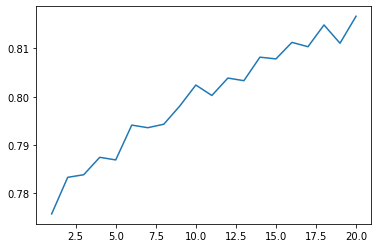

In [9]:
# Base LSTM Model
lstm_model = RNNClassifier(
    rnn_type="LSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_glove
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = lstm_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

#### fastText

After epoch 1 the validation accuracy is 0.783.
the best model has validation accuracy at 0.7827499097798629
After epoch 2 the validation accuracy is 0.792.
the best model has validation accuracy at 0.7915914832190545
After epoch 3 the validation accuracy is 0.795.
the best model has validation accuracy at 0.7948394081559004
After epoch 4 the validation accuracy is 0.792.
After epoch 5 the validation accuracy is 0.804.
the best model has validation accuracy at 0.8042223024178997
After epoch 6 the validation accuracy is 0.803.
After epoch 7 the validation accuracy is 0.808.
the best model has validation accuracy at 0.8080115481775533
After epoch 8 the validation accuracy is 0.805.
After epoch 9 the validation accuracy is 0.808.
After epoch 10 the validation accuracy is 0.809.
the best model has validation accuracy at 0.80873330927463
After epoch 11 the validation accuracy is 0.811.
the best model has validation accuracy at 0.8112594731143992
After epoch 12 the validation accuracy is 0.8

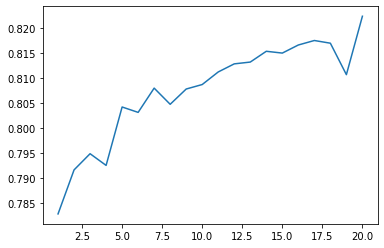

In [10]:
# Base LSTM Model
lstm_model = RNNClassifier(
    rnn_type="LSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_fasttext
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = lstm_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)


### BiLSTM
#### GloVe


After epoch 1 the validation accuracy is 0.789.
the best model has validation accuracy at 0.7888848791050163
After epoch 2 the validation accuracy is 0.800.
the best model has validation accuracy at 0.8000721761097077
After epoch 3 the validation accuracy is 0.815.
the best model has validation accuracy at 0.8150487188740527
After epoch 4 the validation accuracy is 0.839.
the best model has validation accuracy at 0.8386863948033201
After epoch 5 the validation accuracy is 0.850.
the best model has validation accuracy at 0.8496932515337423
After epoch 6 the validation accuracy is 0.836.
After epoch 7 the validation accuracy is 0.853.
the best model has validation accuracy at 0.8534824972933959
After epoch 8 the validation accuracy is 0.856.
the best model has validation accuracy at 0.8560086611331649
After epoch 9 the validation accuracy is 0.856.
the best model has validation accuracy at 0.8561891014074341
After epoch 10 the validation accuracy is 0.860.
the best model has validation a

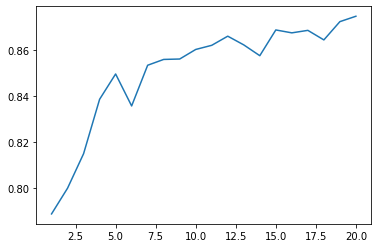

: 

In [7]:
# BiLSTM Model with BoW
bilstm_bow_model = RNNClassifier(
    rnn_type="BiLSTM",
    input_size=10000,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_bow
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = bilstm_bow_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

After epoch 1 the validation accuracy is 0.783.
the best model has validation accuracy at 0.7827499097798629
After epoch 2 the validation accuracy is 0.786.
the best model has validation accuracy at 0.786178274990978
After epoch 3 the validation accuracy is 0.789.
the best model has validation accuracy at 0.7892457596535547
After epoch 4 the validation accuracy is 0.792.
the best model has validation accuracy at 0.7921328040418621
After epoch 5 the validation accuracy is 0.795.
the best model has validation accuracy at 0.7948394081559004
After epoch 6 the validation accuracy is 0.800.
the best model has validation accuracy at 0.8002526163839769
After epoch 7 the validation accuracy is 0.798.
After epoch 8 the validation accuracy is 0.803.
the best model has validation accuracy at 0.8027787802237459
After epoch 9 the validation accuracy is 0.805.
the best model has validation accuracy at 0.8051245037892457
After epoch 10 the validation accuracy is 0.807.
the best model has validation ac

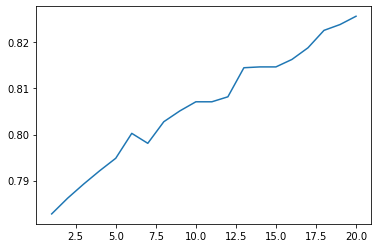

In [23]:
# Bidirectional LSTM Model
bilstm_model = RNNClassifier(
    rnn_type="BiLSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_glove
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = bilstm_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

#### FastText

After epoch 1 the validation accuracy is 0.784.
the best model has validation accuracy at 0.7843738722482858
After epoch 2 the validation accuracy is 0.780.
After epoch 3 the validation accuracy is 0.789.
the best model has validation accuracy at 0.7888848791050163
After epoch 4 the validation accuracy is 0.791.
the best model has validation accuracy at 0.7910501623962468
After epoch 5 the validation accuracy is 0.798.
the best model has validation accuracy at 0.7982677733670155
After epoch 6 the validation accuracy is 0.799.
the best model has validation accuracy at 0.7986286539155539
After epoch 7 the validation accuracy is 0.794.
After epoch 8 the validation accuracy is 0.800.
the best model has validation accuracy at 0.8004330566582462
After epoch 9 the validation accuracy is 0.802.
the best model has validation accuracy at 0.8015156983038614
After epoch 10 the validation accuracy is 0.799.
After epoch 11 the validation accuracy is 0.803.
the best model has validation accuracy at 0

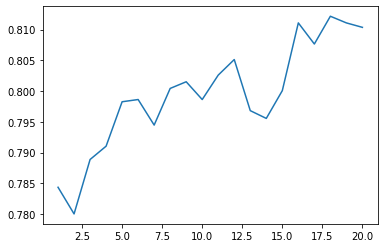

: 

In [24]:
# Bidirectional LSTM Model
bilstm_model = RNNClassifier(
    rnn_type="BiLSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_fasttext
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = bilstm_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)